# rPPG Validation Notebook — v3 (Multi‑patch + Long Window + Prior)


- **Multi‑patch cheeks (2×2 per cheek)** to reduce beard/shadow contamination.
- **Quality‑aware fusion** across patches and across ROIs.
- Still supports:
  - long HR windows
  - prior‑band tracking + hold‑last‑good
  - With or without **IR CSV**

## NPZ compatibility
This notebook works with either format:

### Old/simple NPZ
Keys like:
- `forehead`, `left_cheek`, `right_cheek` (each (T,3))

### multi‑patch
Keys like:
- `forehead` (T,3)
- `left_cheek_00`, `left_cheek_01`, `left_cheek_10`, `left_cheek_11` (T,3)
- `right_cheek_00`, ... (T,3)
Optional aggregate keys (`left_cheek`, `right_cheek`) may also exist.

## What you should see
**Good clip**
- Most patches have a strong PSD peak; HRs cluster tightly.
- Fusion HR is stable; outlier patches are automatically downweighted.

**Bad clip**
- Many patches have low SNR and disagree; acceptance rate drops.

In [28]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
import re

plt.rcParams["figure.figsize"] = (10, 3)

## 1) Paths (edit)

- `NPZ_PATH`: your `*_ppg_data.npz`
- `IR_CSV_PATH`: optional IR CSV (first column samples). Set `None` if not available.

In [ ]:
NPZ_PATH = "../data/processed/508_ppg_data.npz"  # <-- edit
IR_CSV_PATH = None                          # e.g. "data/ir/1_ir.csv" or None

In [30]:
# --- Load NPZ ---
d = np.load(NPZ_PATH, allow_pickle=True)

fps = float(d["fps"])
t = d["timestamps"].astype(float) if "timestamps" in d else np.arange(int(d["frame_count"])) / fps
roi_pixels = d["roi_pixels"] if "roi_pixels" in d.files else None
face_ok = d["face_ok"] if "face_ok" in d.files else None
meta = d["meta"].item() if "meta" in d.files else {}

print("NPZ:", Path(NPZ_PATH).name)
print("fps:", fps, "frames:", len(t), "duration(s):", float(t[-1]) if len(t) else None)
print("meta:", meta if meta else "(none)")

NPZ: 495_ppg_data.npz
fps: 24.97427454208685 frames: 809 duration(s): 32.353294372558594
meta: {'option': 'C_multi_patch_2x2', 'skin_mode': 'ycrcb', 'lower_hsv': (0, 20, 70), 'upper_hsv': (20, 255, 255), 'cr': (133, 173), 'cb': (77, 127), 'forehead_height_ratio': 0.22, 'forehead_width_inset': 0.12, 'cheek_shrink': 0.22, 'cheek_bottom_frac': 0.35, 'nose_margin_px': 12, 'mouth_margin_px': 10, 'jaw_margin_px': 18, 'min_pixels': 120, 'patch_ids': ['00', '01', '10', '11']}


## 2) Discover ROI keys and group them

We auto-detect:
- `forehead`
- cheek patches: `left_cheek_00`, `left_cheek_01`, `left_cheek_10`, `left_cheek_11`
- similarly for right cheek

If your NPZ only has `left_cheek` and `right_cheek`, this still works.

In [31]:
def discover_rois(npz):
    keys = list(npz.files)

    def is_rgb_key(k):
        return k not in ("fps","frame_count","timestamps","roi_pixels","face_ok","meta")

    rgb_keys = [k for k in keys if is_rgb_key(k)]

    # group patches by prefix
    groups = {}
    for k in rgb_keys:
        if k == "forehead":
            groups.setdefault("forehead", []).append(k)
            continue
        m = re.match(r"^(left_cheek|right_cheek)_(\d\d)$", k)
        if m:
            groups.setdefault(m.group(1), []).append(k)
            continue
        if k in ("left_cheek","right_cheek"):
            groups.setdefault(k, []).append(k)

    # sort patch keys nicely (00,01,10,11)
    for g in groups:
        groups[g] = sorted(groups[g])

    return groups

groups = discover_rois(d)
groups

{'forehead': ['forehead'],
 'left_cheek': ['left_cheek',
  'left_cheek_00',
  'left_cheek_01',
  'left_cheek_10',
  'left_cheek_11'],
 'right_cheek': ['right_cheek',
  'right_cheek_00',
  'right_cheek_01',
  'right_cheek_10',
  'right_cheek_11']}

## 3) Sanity plots (optional)
- RGB mean per ROI/patch
- ROI pixel stability (if available)

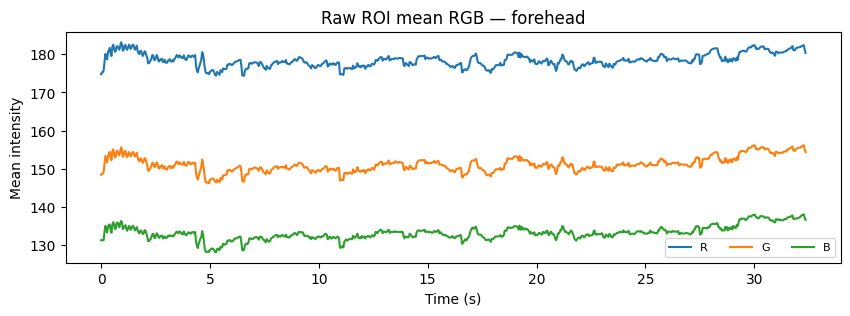

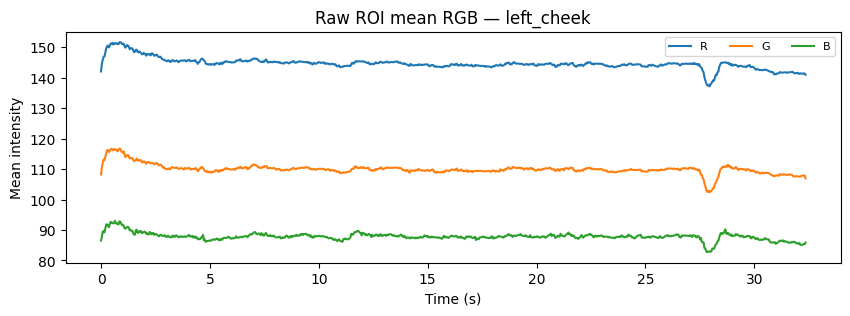

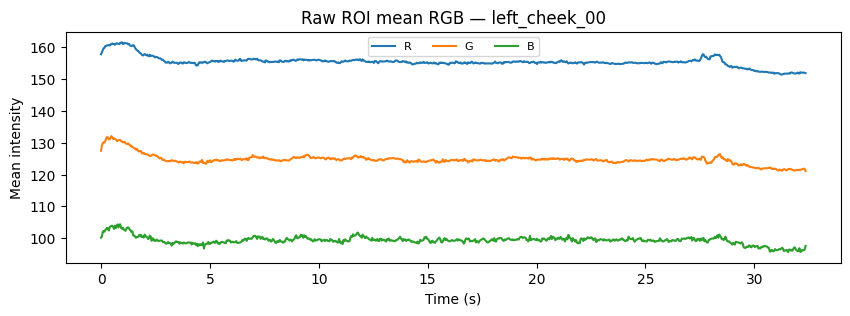

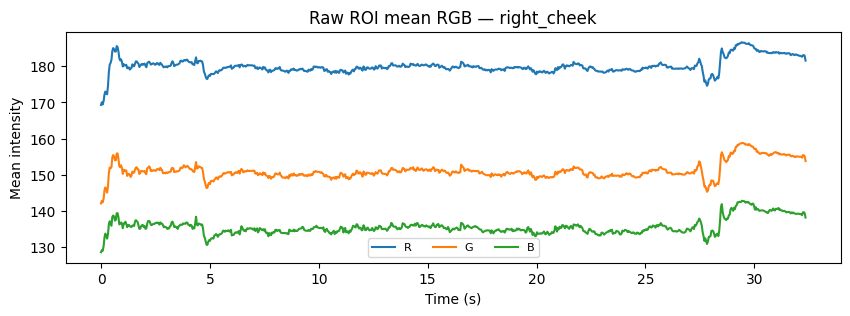

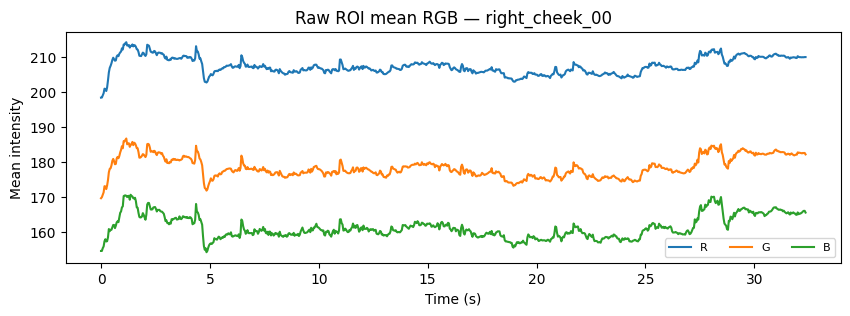

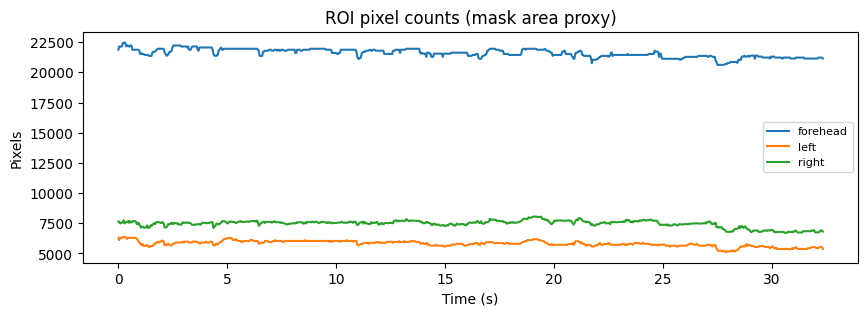

In [32]:
def interp_nans(x, min_valid_ratio=0.7):
    x = np.asarray(x, float)
    good = np.isfinite(x)
    if good.mean() < min_valid_ratio:
        return np.full_like(x, np.nan)
    if good.all():
        return x
    idx = np.arange(len(x))
    y = x.copy()
    y[~good] = np.interp(idx[~good], idx[good], x[good])
    return y

# quick RGB plot for a few keys
show_keys = []
if "forehead" in groups: show_keys += groups["forehead"]
if "left_cheek" in groups: show_keys += groups["left_cheek"][:min(2,len(groups["left_cheek"]))]
if "right_cheek" in groups: show_keys += groups["right_cheek"][:min(2,len(groups["right_cheek"]))]
show_keys = show_keys[:5]

for k in show_keys:
    rgb = d[k].astype(float)
    plt.figure()
    plt.plot(t, interp_nans(rgb[:,0]), label="R")
    plt.plot(t, interp_nans(rgb[:,1]), label="G")
    plt.plot(t, interp_nans(rgb[:,2]), label="B")
    plt.title(f"Raw ROI mean RGB — {k}")
    plt.xlabel("Time (s)")
    plt.ylabel("Mean intensity")
    plt.legend(ncol=3, fontsize=8)
    plt.show()

if roi_pixels is not None:
    plt.figure()
    plt.plot(t, roi_pixels[:,0], label="forehead")
    plt.plot(t, roi_pixels[:,1], label="left")
    plt.plot(t, roi_pixels[:,2], label="right")
    plt.title("ROI pixel counts (mask area proxy)")
    plt.xlabel("Time (s)")
    plt.ylabel("Pixels")
    plt.legend(fontsize=8)
    plt.show()

## 4) rPPG extraction (POS) per ROI/patch

We compute POS rPPG for each ROI key.

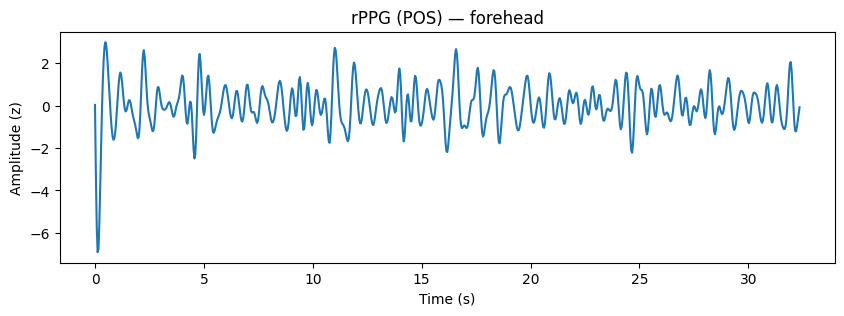

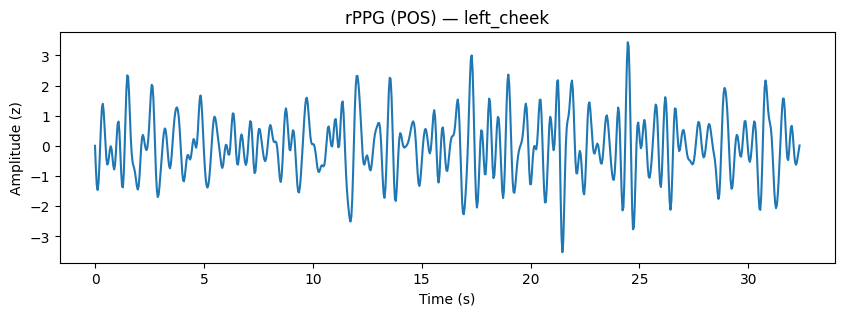

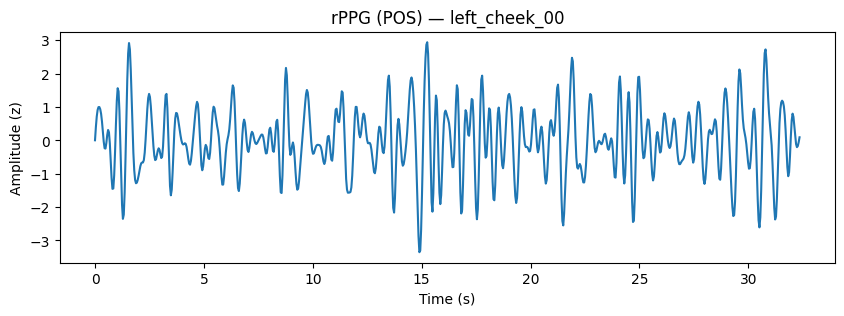

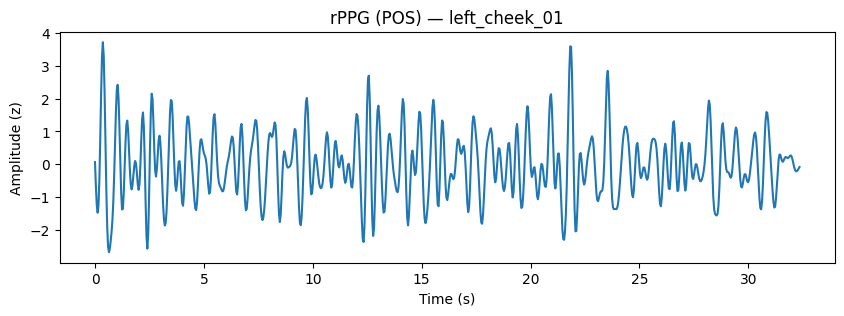

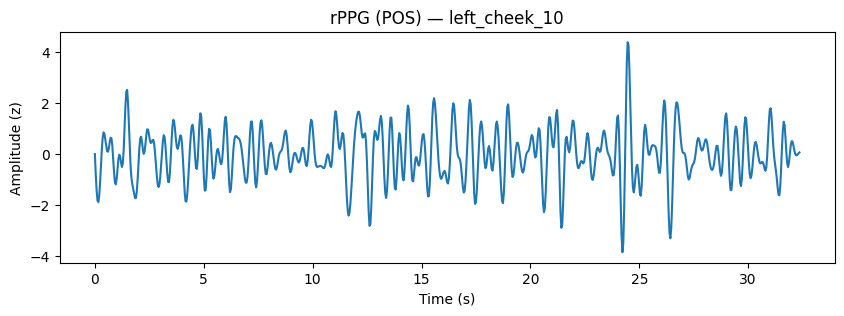

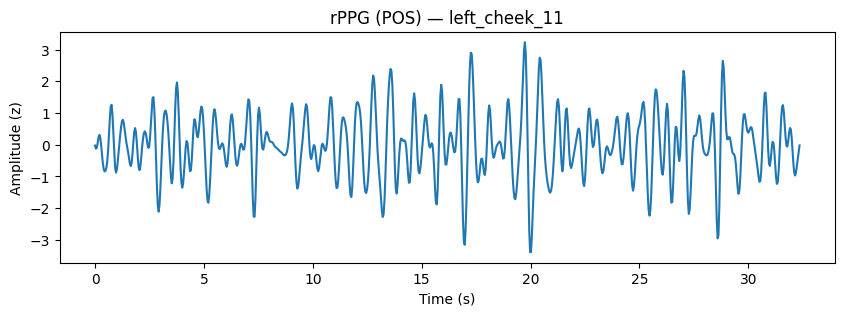

In [33]:
def zscore(x):
    x = np.asarray(x, float)
    return (x - np.mean(x)) / (np.std(x) + 1e-12)

def bandpass(x, fs, lo=0.8, hi=3.0, order=3):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [lo/nyq, hi/nyq], btype="bandpass")
    return signal.filtfilt(b, a, np.asarray(x, float))

def pos_rppg(rgb, fs, win_sec=1.6, overlap=0.5):
    rgb = np.asarray(rgb, float)
    R = interp_nans(rgb[:,0]); G = interp_nans(rgb[:,1]); B = interp_nans(rgb[:,2])
    if not (np.all(np.isfinite(R)) and np.all(np.isfinite(G)) and np.all(np.isfinite(B))):
        return np.full(len(R), np.nan)

    C = np.vstack([R,G,B]).T
    C = C / (np.mean(C, axis=0, keepdims=True) + 1e-12)

    n = len(C)
    win = max(5, int(round(win_sec*fs)))
    hop = max(1, int(round(win*(1-overlap))))
    hann = signal.windows.hann(win, sym=False)

    out = np.zeros(n); wsum = np.zeros(n)
    P = np.array([[0, 1, -1],
                  [-2, 1,  1]], float)

    for s in range(0, n-win+1, hop):
        seg = C[s:s+win] - np.mean(C[s:s+win], axis=0, keepdims=True)
        X = seg @ P.T
        x1, x2 = X[:,0], X[:,1]
        alpha = np.std(x1) / (np.std(x2) + 1e-12)
        sig = x1 - alpha*x2
        sig -= np.mean(sig)

        out[s:s+win] += sig * hann
        wsum[s:s+win] += hann

    out /= np.maximum(wsum, 1e-12)
    out = signal.detrend(out, type="linear")
    out = bandpass(out, fs, 0.8, 3.0, 3)
    return zscore(out)

# compute rPPG for all ROI keys
roi_keys = sorted({k for ks in groups.values() for k in ks})
rppg = {k: pos_rppg(d[k].astype(float), fps) for k in roi_keys}

# quick plot a few
for k in roi_keys[:min(6,len(roi_keys))]:
    plt.figure()
    plt.plot(t, rppg[k])
    plt.title(f"rPPG (POS) — {k}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (z)")
    plt.show()

## 5) HR + SNR (Welch peak)

We compute HR and an SNR-like score per ROI key.

In [34]:
def welch_hr_and_snr(seg, fs, lo=0.8, hi=3.0, guard_hz=0.30):
    seg = np.asarray(seg, float)
    if not np.all(np.isfinite(seg)):
        return np.nan, -np.inf, None, None, None
    f, p = signal.welch(seg, fs=fs, nperseg=min(len(seg), int(8*fs)))
    band = (f >= lo) & (f <= hi)
    if not np.any(band):
        return np.nan, -np.inf, f, p, None

    fb, pb = f[band], p[band]
    i0 = int(np.argmax(pb))
    f0 = float(fb[i0])
    bpm = 60.0 * f0

    num = (fb >= f0-guard_hz) & (fb <= f0+guard_hz)
    den = ~num
    p_num = float(np.sum(pb[num]) + 1e-12)
    p_den = float(np.sum(pb[den]) + 1e-12)
    snr_db = 10.0 * np.log10(p_num / p_den)

    return bpm, snr_db, f, p, f0

overall = []
for k in roi_keys:
    bpm, snr_db, f, p, f0 = welch_hr_and_snr(rppg[k], fps)
    overall.append((k, bpm, snr_db))
df_overall = pd.DataFrame(overall, columns=["ROI_key","HR_bpm","SNR_dB"]).sort_values("SNR_dB", ascending=False)
df_overall

,ROI_key,HR_bpm,SNR_dB
5,left_cheek_11,82.829252,1.570296
10,right_cheek_11,105.419048,0.557033
7,right_cheek_00,60.239456,-0.275510
8,right_cheek_01,60.239456,-0.574818
0,forehead,67.769388,-0.782565
9,right_cheek_10,82.829252,-0.823131
1,left_cheek,75.299320,-1.522904
6,right_cheek,60.239456,-2.027224
2,left_cheek_00,75.299320,-2.081347
3,left_cheek_01,67.769388,-2.573459


## 6) Long window + prior tracking per ROI key

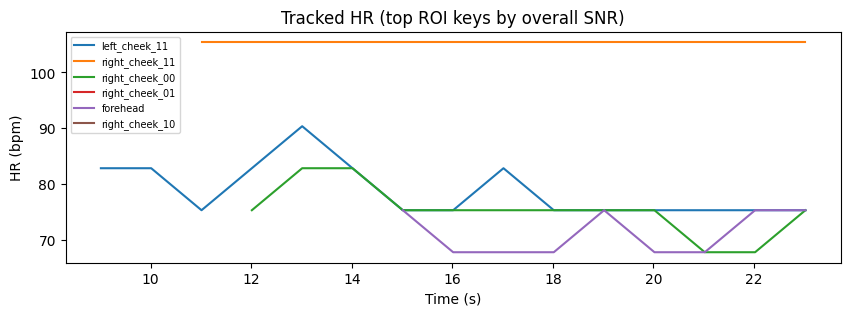

In [35]:
def hr_track_with_prior(
    x, fs,
    win_sec=18.0, hop_sec=1.0,
    lo=0.8, hi=3.0,
    prior_margin_bpm=15.0,
    snr_lock_db=1.0,
    snr_hold_db=0.0,
    hold_last_good=True
):
    x = np.asarray(x, float)
    win = int(round(win_sec * fs))
    hop = int(round(hop_sec * fs))

    times, hr_out, snr_out = [], [], []
    hr_prev = np.nan

    for start in range(0, len(x) - win + 1, hop):
        seg = x[start:start+win]

        if np.isfinite(hr_prev):
            lo_bpm = max(lo*60.0, hr_prev - prior_margin_bpm)
            hi_bpm = min(hi*60.0, hr_prev + prior_margin_bpm)
            lo_hz = lo_bpm / 60.0
            hi_hz = hi_bpm / 60.0
        else:
            lo_hz, hi_hz = lo, hi

        bpm, snr_db, *_ = welch_hr_and_snr(seg, fs, lo_hz, hi_hz)

        if np.isfinite(bpm) and snr_db >= snr_lock_db:
            hr_prev = bpm
            hr_use = bpm
        else:
            if hold_last_good and np.isfinite(hr_prev) and snr_db >= snr_hold_db:
                hr_use = hr_prev
            else:
                hr_use = np.nan

        times.append((start + win/2)/fs)
        hr_out.append(hr_use)
        snr_out.append(snr_db)

    return np.array(times), np.array(hr_out), np.array(snr_out)

WIN_SEC = 18.0
HOP_SEC = 1.0

tracks = {}
for k in roi_keys:
    tt, hr_hat, snr_hat = hr_track_with_prior(rppg[k], fps, win_sec=WIN_SEC, hop_sec=HOP_SEC)
    tracks[k] = dict(t=tt, hr=hr_hat, snr=snr_hat)

# Plot tracked HR for top 6 keys by SNR (overall)
top_keys = df_overall.head(min(6, len(df_overall)))["ROI_key"].tolist()
plt.figure()
for k in top_keys:
    plt.plot(tracks[k]["t"], tracks[k]["hr"], label=k)
plt.title("Tracked HR (top ROI keys by overall SNR)")
plt.xlabel("Time (s)")
plt.ylabel("HR (bpm)")
plt.legend(fontsize=7)
plt.show()

## 7) Patch-level fusion (per cheek)

If you have cheek patches, we fuse them into a single cheek HR per window using a **weighted median**:
- weights = `max(SNR_dB, 0)` (negative SNR contributes ~0 weight)
- then fuse left + right + forehead similarly.

This gives robust HR even when one patch drifts into beard/shadow.

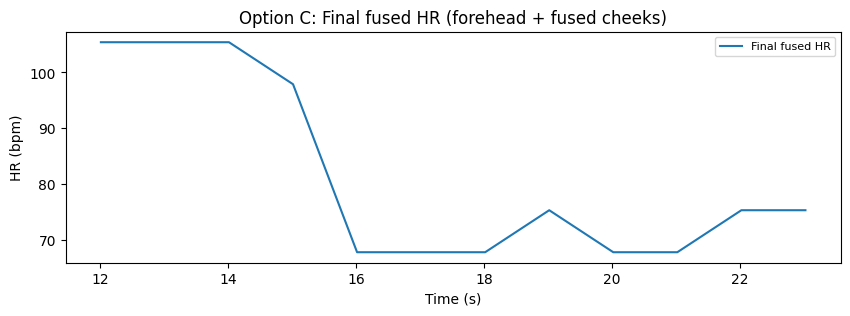

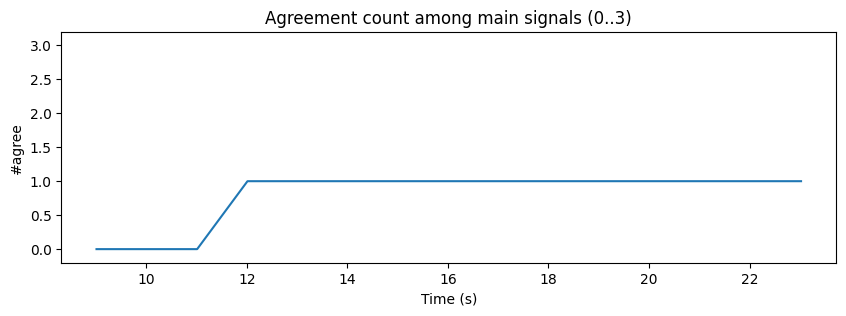

In [36]:
def weighted_median(values, weights):
    values = np.asarray(values, float)
    weights = np.asarray(weights, float)
    m = np.isfinite(values) & np.isfinite(weights) & (weights > 0)
    if not np.any(m):
        return np.nan
    v = values[m]
    w = weights[m]
    order = np.argsort(v)
    v = v[order]; w = w[order]
    cw = np.cumsum(w)
    cutoff = 0.5 * np.sum(w)
    return float(v[np.searchsorted(cw, cutoff)])

def fuse_group(keys, tracks, snr_floor_db=0.0):
    # assumes all keys share same time grid
    grid = tracks[keys[0]]["t"]
    fused = np.full(len(grid), np.nan)
    agree_n = np.zeros(len(grid), int)

    for i in range(len(grid)):
        hrs = np.array([tracks[k]["hr"][i] for k in keys], float)
        snrs = np.array([tracks[k]["snr"][i] for k in keys], float)
        w = np.maximum(snrs - snr_floor_db, 0.0)  # shift so snr_floor => 0
        fused[i] = weighted_median(hrs, w)

        # agreement count (within ±6 bpm of fused) among weighted-valid keys
        valid = np.isfinite(hrs) & (w > 0)
        if np.isfinite(fused[i]):
            agree_n[i] = int(np.sum(valid & (np.abs(hrs - fused[i]) <= 6.0)))
        else:
            agree_n[i] = 0

    return grid, fused, agree_n

# Determine patch keys for each cheek
left_keys = groups.get("left_cheek", [])
right_keys = groups.get("right_cheek", [])

# If only aggregate keys exist, treat them as single-key group
if not left_keys and "left_cheek" in groups:
    left_keys = groups["left_cheek"]
if not right_keys and "right_cheek" in groups:
    right_keys = groups["right_cheek"]

# Forehead is always single key
forehead_keys = groups.get("forehead", ["forehead"])

# Fuse cheeks from patches (if multiple keys), else passthrough
grid, left_fused, left_agree = fuse_group(left_keys, tracks, snr_floor_db=0.0) if left_keys else (tracks["forehead"]["t"], np.full_like(tracks["forehead"]["t"], np.nan, float), np.zeros_like(tracks["forehead"]["t"], int))
_,    right_fused, right_agree = fuse_group(right_keys, tracks, snr_floor_db=0.0) if right_keys else (grid, np.full_like(grid, np.nan, float), np.zeros_like(grid, int))

# Build final fusion across forehead + fused cheeks
# We'll create pseudo-tracks for fused cheeks using a heuristic SNR: median of patch snr per window (clipped)
def fused_snr(keys, tracks):
    if not keys: return np.full_like(grid, -np.inf, float)
    S = np.vstack([tracks[k]["snr"] for k in keys]).T
    return np.nanmedian(S, axis=1)

forehead_track = tracks[forehead_keys[0]]
left_snr = fused_snr(left_keys, tracks)
right_snr = fused_snr(right_keys, tracks)

# Make "tracks" for the three main signals
main_hr = np.vstack([forehead_track["hr"], left_fused, right_fused]).T
main_snr = np.vstack([forehead_track["snr"], left_snr, right_snr]).T
names = ["forehead", "left_fused", "right_fused"]

final = np.full(len(grid), np.nan)
final_agree = np.zeros(len(grid), int)
for i in range(len(grid)):
    hrs = main_hr[i]
    snrs = main_snr[i]
    w = np.maximum(snrs, 0.0)
    final[i] = weighted_median(hrs, w)
    valid = np.isfinite(hrs) & (w > 0)
    if np.isfinite(final[i]):
        final_agree[i] = int(np.sum(valid & (np.abs(hrs - final[i]) <= 6.0)))
    else:
        final_agree[i] = 0

plt.figure()
plt.plot(grid, final, label="Final fused HR")
plt.title("Option C: Final fused HR (forehead + fused cheeks)")
plt.xlabel("Time (s)")
plt.ylabel("HR (bpm)")
plt.legend(fontsize=8)
plt.show()

plt.figure()
plt.plot(grid, final_agree)
plt.ylim(-0.2, 3.2)
plt.title("Agreement count among main signals (0..3)")
plt.xlabel("Time (s)")
plt.ylabel("#agree")
plt.show()

## 8) Optional IR validation (if IR_CSV_PATH provided)

Compares final fused HR against IR HR track (windowed).

In [37]:
def load_ir_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df.iloc[:,0].astype(float).to_numpy()

def hr_track_basic(x, fs, win_sec=18.0, hop_sec=1.0, lo=0.8, hi=3.0):
    win = int(round(win_sec*fs))
    hop = int(round(hop_sec*fs))
    tt, hh = [], []
    for start in range(0, len(x)-win+1, hop):
        seg = x[start:start+win]
        bpm, *_ = welch_hr_and_snr(seg, fs, lo, hi)
        tt.append((start+win/2)/fs)
        hh.append(bpm)
    return np.array(tt), np.array(hh)

if IR_CSV_PATH is None:
    print("IR_CSV_PATH is None. Skip IR validation.")
else:
    ir_raw = load_ir_csv(IR_CSV_PATH)
    duration = float(t[-1] - t[0])
    fs_ir_est = float(len(ir_raw) / duration) if duration > 0 else np.nan

    # preprocess IR and map to video time
    ir_bp = bandpass(signal.detrend(ir_raw, type="linear"), fs_ir_est, 0.8, 3.0, 3)
    ir_bp = zscore(ir_bp)
    t_ir = np.arange(len(ir_raw)) / fs_ir_est
    ir_on_video = np.interp(t, t_ir, ir_bp)

    # IR HR track (windowed)
    t_ir_hr, hr_ir = hr_track_basic(ir_on_video, fps, win_sec=WIN_SEC, hop_sec=HOP_SEC)

    # Compare on common grid (they should match exactly here)
    # (grid from fusion should match t_ir_hr length if using same win/hop)
    n = min(len(grid), len(t_ir_hr))
    err = final[:n] - hr_ir[:n]
    mae = float(np.nanmean(np.abs(err)))
    rmse = float(np.sqrt(np.nanmean(err**2)))

    plt.figure()
    plt.plot(t_ir_hr[:n], hr_ir[:n], label="IR HR")
    plt.plot(grid[:n], final[:n], label="Fused HR")
    plt.title(f"IR vs Fused HR (MAE={mae:.2f} bpm, RMSE={rmse:.2f} bpm)")
    plt.xlabel("Time (s)")
    plt.ylabel("HR (bpm)")
    plt.legend(fontsize=8)
    plt.show()

IR_CSV_PATH is None. Skip IR validation.


## 9) Interpretation hints

- If **patches disagree**, check which patch has low SNR; it likely overlaps beard/shadow/lips.
- If **final_agree** is mostly 2–3, clip is reliable.
- If **final_agree** is often 0–1 and SNR is negative across most patches, mark the clip as unreliable.